# Questions

1. Do we have to transform this heterogeneous pbl into a homogeneous one ? 
2. Don't understand why the boudaries should be [1,1] despite the domain we are studying is [-1,1] so the boudaries should be [-1,1] ?
3. Does stiffness matrix really is 5*5 ? Or is this just an example ? 
4. Is it right that Galerkin method is only the moment when we are discretoring the weak formulation and not the weak formulation itself ?4

# Answers 

1. No but it's a way to do it 
2. Probably a typo ask Davide
3. Just an example should be N*N
4. Kind of blury, it's between those 2 bc it really starts when we are multplying by the test function v

# Problem 1

We want to implement P1-FEM in 1D. For benchmarking, we use a simple Poisson problem in 1D:
$$
    \begin{cases}
        -u''=f\quad&\text{in }\Omega=(-1,1),\\
        u(-1)=u_0(-1),\quad&\\
        u'(1)=g(1),\quad&\\
    \end{cases}
$$
with $f(x)=9\sin(3x+3)$, $u_0(-1)=0$, and $g(1)=3\cos(6)$. The exact solution is $u(x)=\sin(3x+3)$.

In [2098]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.linalg as la

import scipy.sparse as sp
import scipy.sparse.linalg as spla
h = 0.1

## (a)

First of all, the function $f$ is smooth enough to write $f(x)=9*sin(3*x+3) \in L^2 \implies u^{\prime\prime} \in L^2$ and the regularity of such elliptic PDE allows us to write that $u\in \mathcal{H}^2$.

We recall the definition of the $\mathcal{H}^2$ Sobolev space : 

$$
\mathcal{H}^2(-1,1) = \left\{v \in L^2(-1,1) : v^{(k)} \in L^2(-1,1) \quad \forall |k|\leq 2\right\} 
$$

In order to derive a weak (Galerkin) formulation of the problem, we shall start by multiplying equation      by a (so far arbitrary) test function $v$ and integrating, on the domain, here the interval (-1,1). To simplify the writing, we will now write $u(x)$ as $u$.



$$- \int_{-1}^{1} u^{\prime \prime}vdx = \int_{-1}^{1} fvdx$$

We then integrate by parts the first integral, with the purpose of eliminating the second
derivative, in order to impose a lower regularity on the solution. We find

$$- \left( [u^{\prime}v]_{-1}^{1} - \int_{-1}^{1} u^{\prime}v^{\prime}dx \right) = \int_{-1}^{1} fvdx \implies \int_{-1}^{1} u^{\prime}v^{\prime}dx = \int_{-1}^{1} fvdx - u^{\prime}(-1)v(-1) + u^{\prime}(1)v(1)$$

In such case, we want the test function null in $x=-1$ because we have no information regarding $u^{\prime}(-1)$. Therefore, we are setting $\Gamma_- = \{-1\}$ and defining the trial space by the following Sobolev space :

$$
\mathcal{H}^2_{\Gamma_-}(-1,1) = \left\{ v \in \mathcal{H}^2 : v(-1) = 0 \right\}
$$

Consequently, we looking for the solution of $u$ such that : 

$$
u \in \mathcal{H}^2_{\Gamma_-}(-1,1) : \int_{-1}^{1} u^{\prime}v^{\prime}dx = \int_{-1}^{1} fvdx + g(1)v(1)\quad \forall v \in \mathcal{H}^2_{\Gamma_-}(-1,1)
$$

We can also rewrite this equation by the following bilinear system :
$$
u \in \mathcal{H}^2_{\Gamma_-}(-1,1) : a(u,v) = b(v) \quad \forall v \in \mathcal{H}^2_{\Gamma_-}(-1,1)
$$

To sum up, we derived a weak (Galerkin) formulation from the strong one of the initial problem. We also defined the trial space $ \mathcal{H}^2_{\Gamma_-}(-1,1) $ in which both functions are.

* $\mathcal{V}_{\Gamma_-}=\mathcal{H}^2_{\Gamma_-}=\left\{ u \in L^2(-1,1) : u^{(k)} \in L^2(-1,1) \quad \forall |k|\leq 2 | u(-1) = 0 \right\}$
* $a(u,v)=\int_{-1}^{1}u^{\prime}v^{\prime}dx$
* $b(v)=\int_{-1}^{1} fvdx + g(1)v(1)$

# Well-posedness ? 

We have to prove :

1. the problem has a solution
2. this solution is unique
3. The solution depends continuously on the data and the parameters



In [2099]:
def trace(convergence_Linf, convergence_L2, convergence_H1, h_values, errors_Linf, errors_L2, errors_H1, condK_values=None):
    
    print(f"\nOrdre de convergence estimé :")
    print(f"L∞ : {convergence_Linf:.2f} : pareil que pour L2 voir class 7 pour jutsif dans le tableau grand O(h^2)")
    print(f"L2  : {convergence_L2:.2f} : proche de 2 parfait voir class 7 pour jutsif dans le tableau grand O(h^2)")
    print(f"H1  : {convergence_H1:.2f} : proche de 1 parfait voir class 7 pour jutsif dans le tableau grand O(h)")

    plt.figure(figsize=(8,6))
    plt.loglog(h_values, errors_Linf, 'o-', label="Erreur $L^{\infty}$")
    plt.loglog(h_values, errors_L2, 's-', label="Erreur $L^2$")
    plt.loglog(h_values, errors_H1, 'd-', label="Erreur $H^1$")

    plt.xlabel("h (taille du maillage)")
    plt.ylabel("Erreur")
    plt.title("Évolution des erreurs en fonction de h")
    plt.legend()
    plt.grid(True, which="both", linestyle="--")
    plt.show()

    if condK_values != None:
        plt.figure(figsize=(8,6))
        plt.loglog(h_values, condK_values, 'o-', label="Condition number")
        plt.xlabel("h (taille du maillage)")
        plt.ylabel("Conditionnement de K")
        plt.title("Évolution du conditionnement en fonction de h")
        plt.grid(True, which="both", linestyle="--")
        plt.legend()
        plt.show()
    return 0

def linear_regression_convergence(h_values, errors_Linf, errors_L2, errors_H1):
    # Convertir en log
    log_h = np.log(h_values)
    log_Linf = np.log(errors_Linf)
    log_L2 = np.log(errors_L2)
    log_H1 = np.log(errors_H1)

    # Régression linéaire pour trouver la pente (ordre de convergence)
    convergence_Linf, _ = np.polyfit(log_h, log_Linf, 1)
    convergence_L2, _ = np.polyfit(log_h, log_L2, 1)
    convergence_H1, _ = np.polyfit(log_h, log_H1, 1)
    return convergence_Linf, convergence_L2, convergence_H1

## (b)

Implement a function that computes the four mesh-related quantities `grid`, `elements`, `endpoints`, and `boundaries`.

In [2100]:
def createmesh1D(h, domain=(-1, 1), boundaries_flags=[1, 2]):

    a, b = domain
    N = int((b - a) / h)
    h = (b - a) / N  # ensure integer number of elements
    
    grid = np.linspace(a, b, N + 1)
    elements = [[i, i + 1] for i in range(N)]
    endpoints = [0, N]
    boundaries = [a, b]
    boundaries_flags = boundaries_flags
    
    return grid, elements, endpoints, boundaries, boundaries_flags

In [2101]:
# check your implementation of createmesh1D
from pickle import load
data = createmesh1D(0.1)
with open("check/createmesh1D_k1.pkl", "rb") as f: data_ex = load(f)
for dat, dat_ex, name in zip(data, data_ex,
                             ["grid", "elements", "endpoints", "boundaries"]):
    print(f"'{name}' should be {dat_ex}\ncomputed '{name}' is {dat}\n")

'grid' should be [-1.  -0.9 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3
  0.4  0.5  0.6  0.7  0.8  0.9  1. ]
computed 'grid' is [-1.  -0.9 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3
  0.4  0.5  0.6  0.7  0.8  0.9  1. ]

'elements' should be [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11], [11, 12], [12, 13], [13, 14], [14, 15], [15, 16], [16, 17], [17, 18], [18, 19], [19, 20]]
computed 'elements' is [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11], [11, 12], [12, 13], [13, 14], [14, 15], [15, 16], [16, 17], [17, 18], [18, 19], [19, 20]]

'endpoints' should be [0, 20]
computed 'endpoints' is [0, 20]

'boundaries' should be [1, 1]
computed 'boundaries' is [-1, 1]



## (c)

Implement a function that assembles the P1-FEM LHS matrix.

In [2102]:
def assemble_LHS_poisson(mesh, H=lambda x: 1):

    grid, elements, endpoints, boundaries, boundaries_flags = mesh

    K_ref = np.array([[1., -1.], [-1., 1.]])
    N=len(grid)
    K = np.zeros((N,N))

    for el in elements :

        i, j = el
        h = grid[j] - grid[i]
        K_temp =  (1. / h) * K_ref

        K[i,i] += K_temp[0,0]
        K[i,j] += K_temp[0,1]
        K[j,i] += K_temp[1,0]
        K[j,j] += K_temp[1,1]

    for j, flag in zip(endpoints, boundaries_flags):
        
        if flag == 1: 
            K[j, :] = 0
            K[j, j] = 1
        elif flag == 3:  
            K[j, j] += H(grid[j]) 

    return K

In [2103]:
# check your implementation of assemble_LHS_poisson
from pickle import load
mat = assemble_LHS_poisson(createmesh1D(0.1))
with open("check/assemble_LHS_poisson.pkl", "rb") as f: mat_ex = load(f)
print(f"stiffness matrix should be \n{mat_ex}\ncomputed stiffness matrix is \n{mat}")

stiffness matrix should be 
[[ 1.  0.  0.  0.  0.]
 [-2.  4. -2.  0.  0.]
 [ 0. -2.  4. -2.  0.]
 [ 0.  0. -2.  4. -2.]
 [ 0.  0.  0. -2.  2.]]
computed stiffness matrix is 
[[  1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.]
 [-10.  20. -10.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.]
 [  0. -10.  20. -10.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.]
 [  0.   0. -10.  20. -10.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0. -10.  20. -10.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0. -10.  20. -10.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0. -10.  20. -10.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0. -10.  20. -10.   0.   0.

## (d)

Write a function that assembles the P1-FEM RHS vector.

In [2104]:
def quadrature_simpson(domain,integrand, n=2):
    a, b = domain
    if n % 2 == 1:
        n += 1
    
    h = (b - a) / n
    x = np.linspace(a, b, n + 1)
    y = integrand(x)
    
    integral = (h / 3) * (y[0] + 4 * np.sum(y[1:n:2]) + 2 * np.sum(y[2:n-1:2]) + y[n])
    
    return integral

def quadrature_Gauss_test(domain, integrand, n=2):
    a, b = domain
    nodes, weights = np.polynomial.legendre.leggauss(n)
    nodes = 0.5 * (b - a) * nodes + 0.5 * (a + b)
    approximation = 0.5 * (b - a) * sum(weights * integrand(nodes))
    return approximation

def assemble_RHS_poisson(mesh, u0, f, g):

    grid, elements, endpoints, boundaries, boundaries_flags = mesh
    vec = np.zeros(len(grid))
    
    for el in elements:  
        a, b = grid[el[0]], grid[el[1]]
        integral_value = quadrature_simpson((a, b), f)
        vec[el[0]] += integral_value / 2  
        vec[el[1]] += integral_value / 2

    for j, flag in zip(endpoints, boundaries_flags): 

        if flag == 2:
            vec[j] += g(grid[j])
        elif flag == 3:
            vec[j] += g(grid[j])
        elif flag == 1:
            vec[j] = u0(grid[j])

    return vec



In [2105]:
# check your implementation of quadrature1D
from pickle import load
val = quadrature_simpson([0., 1.], lambda x: 4 * x ** 3)
val3 = quadrature_Gauss_test([0., 1.], lambda x: 4 * x ** 3)
print(f"integral value is 1.\nuser-approximated value is {val} with Simpson quadrature and {val3} with scipy Gaussian quadrature")
print("NOTE: results may vary slightly depending on the implemented quadrature formula")

integral value is 1.
user-approximated value is 1.0 with Simpson quadrature and 0.9999999999999999 with scipy Gaussian quadrature
NOTE: results may vary slightly depending on the implemented quadrature formula


In [2106]:
# check your implementation of assemble_RHS_poisson
from pickle import load
vec = assemble_RHS_poisson(createmesh1D(0.1), lambda x: 0.,
                           lambda x: 9 * np.sin(3 * x + 3),
                           lambda x: 3 * np.cos(6))
with open("check/assemble_RHS_poisson.pkl", "rb") as f: vec_ex = load(f)
print(f"RHS vector should be \n{vec_ex}\ncomputed RHS vector is \n {vec}\n")
print("NOTE: results may vary slightly depending on the implemented quadrature formula")

RHS vector should be 
[ 0.          0.2639992   0.50441614  0.69977508  0.8326252   0.89109939
  0.86997433  0.77113705  0.6034164   0.38179435  0.12606776 -0.1409201
 -0.39531998 -0.61440711 -0.77861107 -0.87326403 -0.88991092 -0.82706471
 -0.69033928 -0.49194789  2.71311995]
computed RHS vector is 
 [ 0.          0.26199732  0.50059119  0.69446875  0.82631148  0.88434227
  0.86337739  0.76528959  0.59884074  0.37889924  0.12511179 -0.13985151
 -0.3923223  -0.60974811 -0.77270694 -0.86664215 -0.8831628  -0.82079315
 -0.6851045  -0.48821749  2.69232408]

NOTE: results may vary slightly depending on the implemented quadrature formula


## (e)

Compute and plot the P1-FE solution.

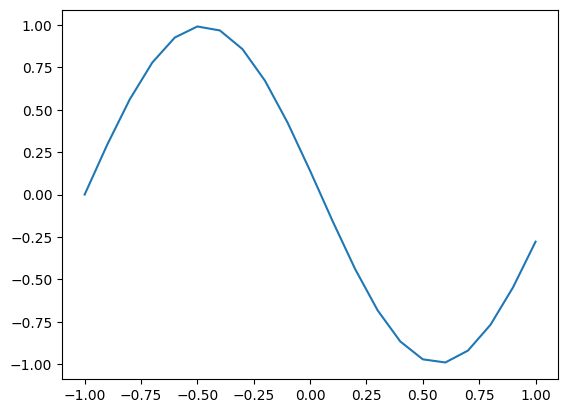

In [2107]:
def solve_poisson(h):
    
    K = assemble_LHS_poisson(createmesh1D(h))
    F = assemble_RHS_poisson(createmesh1D(h), lambda x: 0.,
                             lambda x: 9 * np.sin(3 * x + 3),
                             lambda x: 3 * np.cos(6))
    
    K_LU = la.lu_factor(K)
    uh = la.lu_solve(K_LU, F)
    return uh

uh = solve_poisson(h)
#print(uh)
plt.plot(createmesh1D(h)[0], uh)
plt.show()

Compute the FE error in the $L^\infty(\Omega), L^2(\Omega)$- and $H^1(\Omega)$-norms.

In [2108]:
def eval_uh_Linf(mesh, uh, x, u_exact):
    uh_x = np.interp(x, mesh[0], uh)
    #u_exact = np.sin(3*x + 3)
    error_Linf = np.max(np.abs(uh_x - u_exact))
    return error_Linf

def eval_uh_L2norm(mesh, uh, x, u_exact):
    uh_L2 = np.interp(x, mesh[0], uh)
    #u_exact = np.sin(3*x + 3)
    uh_L2_carré = (uh_L2 - u_exact)**2
    error_L2_inter = np.trapezoid(uh_L2_carré, x)
    error_L2_norm = np.sqrt(error_L2_inter)
    return error_L2_norm

def eval_uh_H1norm(mesh, uh, x, u_exact):
    uh_H1 = np.interp(x, mesh[0], uh)
    #u_exact = np.sin(3*x + 3)
    #u_exact_prime = 3*np.cos(3*x + 3)
    u_exact_prime_diff = np.diff(u_exact) / np.diff(x)
    uh_H1_prime = np.diff(uh_H1) / np.diff(x)
    squared = (uh_H1_prime - u_exact_prime_diff)**2
    error_H1_norm = np.sqrt(np.trapezoid(squared, x[:-1]) + eval_uh_L2norm(mesh, uh, x,u_exact)**2)
    return error_H1_norm

h = 0.1
u_exact = np.sin(3*np.linspace(-1, 1, 10**4) + 3)
mesh = createmesh1D(h)

error_Linf = eval_uh_Linf(mesh, uh, np.linspace(-1, 1, 10**4), u_exact)
error_L2_norm = eval_uh_L2norm(mesh, uh, np.linspace(-1, 1, 10**4), u_exact)
error_H1_norm = eval_uh_H1norm(mesh, uh, np.linspace(-1, 1, 10**4), u_exact)

print(error_Linf)
print(error_L2_norm)
print(error_H1_norm)

0.01860441992789308
0.015635184661479857
0.26604858319854824


## (f)

Solve the problem on a sequence of finer and finer meshes. Identify the convergence rates of the errors.

Evaluation des erreurs pour différentes valeurs de h et différents types de normes :

h = 0.5: L∞ = 0.353, L2 = 0.348, H1 = 1.429
h = 0.25: L∞ = 0.111, L2 = 0.095, H1 = 0.679
h = 0.125: L∞ = 0.029, L2 = 0.024, H1 = 0.333
h = 0.0625: L∞ = 0.007, L2 = 0.006, H1 = 0.166
h = 0.03125: L∞ = 0.002, L2 = 0.002, H1 = 0.082
h = 0.015625: L∞ = 0.000, L2 = 0.000, H1 = 0.041

Ordre de convergence estimé :
L∞ : 1.94 : pareil que pour L2 voir class 7 pour jutsif dans le tableau grand O(h^2)
L2  : 1.97 : proche de 2 parfait voir class 7 pour jutsif dans le tableau grand O(h^2)
H1  : 1.02 : proche de 1 parfait voir class 7 pour jutsif dans le tableau grand O(h)


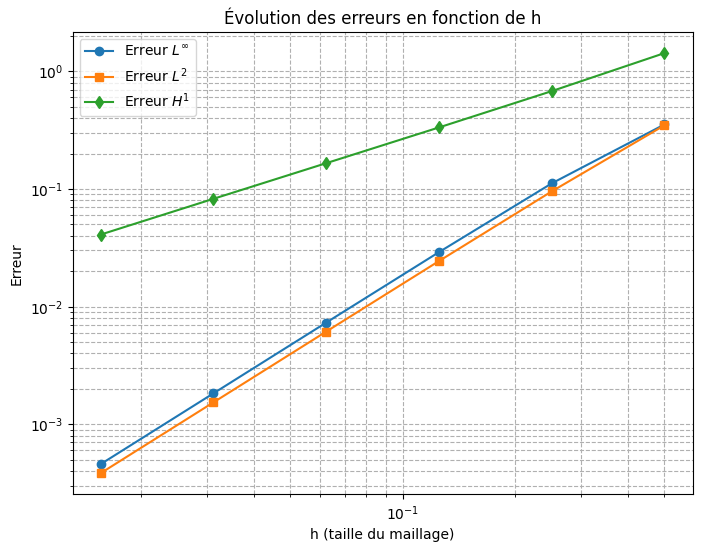

0

In [2109]:

h_values = []
errors_Linf = []
errors_L2 = []
errors_H1 = []

print("Evaluation des erreurs pour différentes valeurs de h et différents types de normes :\n")

for j in range(1, 7):
    h = 2**(-j)
    uh = solve_poisson(h)
    mesh = createmesh1D(h)
    x = np.linspace(-1, 1, 10**4)
    
    error_Linf = eval_uh_Linf(mesh, uh, x, u_exact)
    error_L2_norm = eval_uh_L2norm(mesh, uh, x, u_exact)
    error_H1_norm = eval_uh_H1norm(mesh, uh, x, u_exact)
    
    h_values.append(h)
    errors_Linf.append(error_Linf)
    errors_L2.append(error_L2_norm)
    errors_H1.append(error_H1_norm)
    
    print(f"h = {h}: L∞ = {error_Linf:.3f}, L2 = {error_L2_norm:.3f}, H1 = {error_H1_norm:.3f}")
    
convergence_Linf, convergence_L2, convergence_H1 = linear_regression_convergence(h_values, errors_Linf, errors_L2, errors_H1)

trace(convergence_Linf, convergence_L2, convergence_H1, h_values, errors_Linf, errors_L2, errors_H1)


## (g)

Solve the problem on a sequence of finer and finer meshes. Identify the convergence rates of the FEM matrix's condition number.

for h = 0.5 : cond(K) = 32.654
for h = 0.25 : cond(K) = 120.883
for h = 0.125 : cond(K) = 453.121
for h = 0.0625 : cond(K) = 1740.113
for h = 0.03125 : cond(K) = 6804.142
for h = 0.015625 : cond(K) = 26892.458


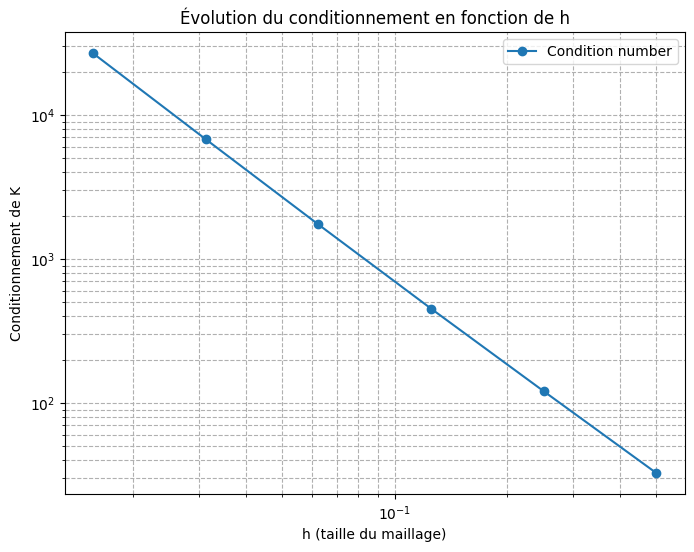

In [2110]:
h_values = []
condK_values = []
for j in range(1, 7):
    h = 2**(-j)
    K = assemble_LHS_poisson(createmesh1D(h))
    condK = np.linalg.cond(K)
    condK_values.append(condK)
    h_values.append(h)
    print(f"for h = {h} : cond(K) = {condK:.3f}")

plt.figure(figsize=(8,6))
plt.loglog(h_values, condK_values, 'o-', label="Condition number")
plt.xlabel("h (taille du maillage)")
plt.ylabel("Conditionnement de K")
plt.title("Évolution du conditionnement en fonction de h")
plt.grid(True, which="both", linestyle="--")
plt.legend()
plt.show()


# Conditionnement 

Le conditionnement de la matrice à l'air d'augmenter quand h tend vers 0. Ceci peut s'expliquer par la difficulté à inverser la matrice de rigidité. En effet, quand h tend vers 0, N tend vers l'infini et donc la taille de la matrice aussi. 

## (h)

Derive two weak formulations for a modified problem with non-homogeneous Dirichlet BCs.

$$

\begin{cases}
-u^{\prime\prime} = f \\
u(-1) = u_0(-1) = -\pi \\
u^{\prime}(1) = g(1) = 3*cos(6)
\end{cases}

$$

1) Petrov-Galerkin
We can start from the weak previously obtained :
$$
    \int_{-1}^{1} u^{\prime}v^{\prime}dx = \int_{-1}^{1} fvdx - u^{\prime}(-1)v(-1) + u^{\prime}(1)v(1)
$$
Then, we modified the Sobolev's space we were working in, in a such way that the test function is still null at $x = -1$ but the solution's space shall also respect the boundary condition at $x=-1$:
$$
    v \in \mathcal{V}_{\Gamma_-}=\left\{ v \in \mathcal{H}^2(-1,1), v(-1) = 0 \right\} 
$$
$$
    u\in \mathcal{V}_{u_0} =\left\{ u \in \mathcal{H}^2(-1,1), u(-1) = -\pi \right\}
$$

2) Lifting.

In order to transform this Petrov-Galerkin problem into a Galerkin one, we must 
$$
\mathring{u} = u - \bar{u}
$$
with $\mathring{u} \in \mathcal{V}_{\Gamma_-}$ which means that the boundaries conditions respect 
$$
\begin{cases}
    \mathring{u}(-1) = u(-1) - \bar{u}(-1) = 0 \\
    \mathring{u}^{\prime}(1) = u^{\prime}(1) - \bar{u}^{\prime}(1) = g(1)
\end{cases}
\implies
\begin{cases}
    \bar{u}(-1) = \bar{u}(x) = -\pi\\
    \bar{u}^{\prime}(x) = 0
\end{cases}
$$

Hence, we can write the Galerkin problem :

$$
\begin{cases}
    - \mathring{u}^{\prime\prime} = f \\
    \mathring{u}(-1) = 0 \\
    \mathring{u}^{\prime}(1) = g(1)

\end{cases}
$$
Its weak form is then the same as the one from the question a :
$$
    \int_{-1}^{1} \mathring{u}^{\prime}v^{\prime}dx = \int_{-1}^{1} fvdx + g(1)v(1)
$$

Obviously, the well-posedness of the Galerkin formulation after lifting is easier to prove and easier to code.

Solve the non-homogeneous problem and study the convergence rates.

Solution numérique pour équation de poisson non-homogène u_h2 = [-3.142 -2.848 -2.581 -2.364 -2.217 -2.152 -2.175 -2.285 -2.471 -2.717
 -3.002 -3.298 -3.581 -3.824 -4.007 -4.112 -4.13  -4.06  -3.909 -3.688
 -3.419]


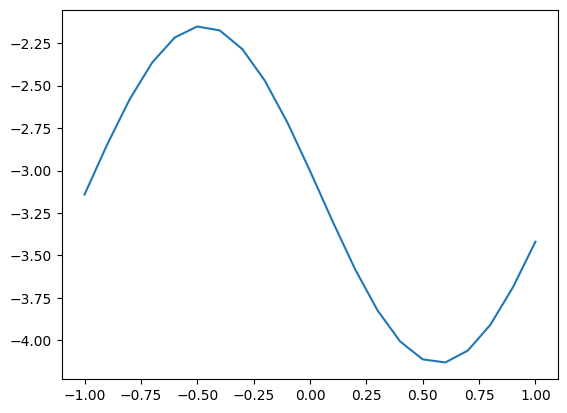

h = 0.5: L∞ = 0.353, L2 = 0.348, H1 = 1.429
h = 0.25: L∞ = 0.111, L2 = 0.095, H1 = 0.679
h = 0.125: L∞ = 0.029, L2 = 0.024, H1 = 0.333
h = 0.0625: L∞ = 0.007, L2 = 0.006, H1 = 0.166
h = 0.03125: L∞ = 0.002, L2 = 0.002, H1 = 0.082
h = 0.015625: L∞ = 0.000, L2 = 0.000, H1 = 0.041

Ordre de convergence estimé :
L∞ : 1.94 : pareil que pour L2 voir class 7 pour jutsif dans le tableau grand O(h^2)
L2  : 1.97 : proche de 2 parfait voir class 7 pour jutsif dans le tableau grand O(h^2)
H1  : 1.02 : proche de 1 parfait voir class 7 pour jutsif dans le tableau grand O(h)


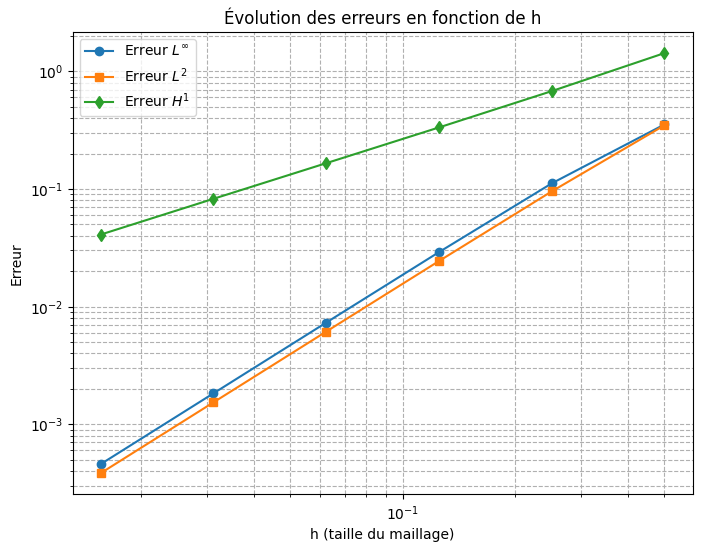

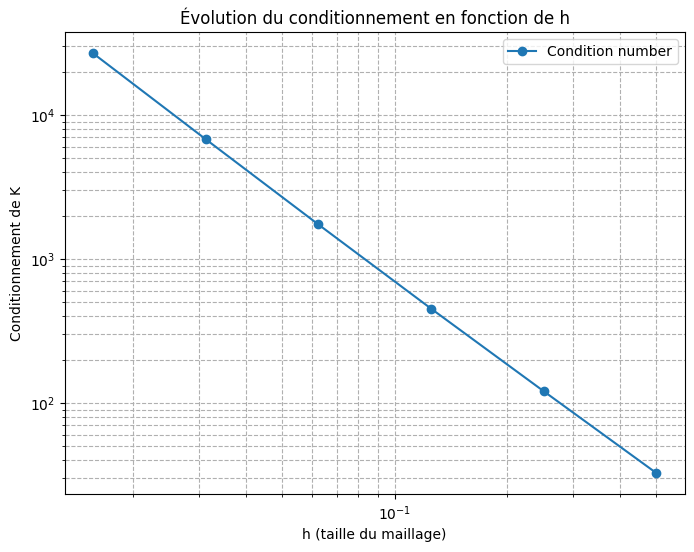

0

In [2111]:
def solve_poisson_nonhomogeneous(h):
    """
    Function to compute the P1-FEM solution uh of the problem with non-homogeneous Dirichlet BCs with mesh-size h.
    """
    K = assemble_LHS_poisson(createmesh1D(h))
    F = assemble_RHS_poisson(createmesh1D(h), lambda x: 0.,
                             lambda x: 9 * np.sin(3 * x + 3),
                             lambda x: 3 * np.cos(6))
    
    K_LU = la.lu_factor(K)
    uh2 = la.lu_solve(K_LU, F) - np.pi
    return uh2

h = 0.1
uh2 = solve_poisson_nonhomogeneous(h)
print(f'Solution numérique pour équation de poisson non-homogène u_h2 = {np.round(uh2,3)}')
plt.plot(createmesh1D(h)[0], uh2)
plt.show()

h_values = []
errors_Linf = []
errors_L2 = []
errors_H1 = []

for j in range(1, 7):
    h = 2**(-j)
    u_exact = np.sin(3*np.linspace(-1, 1, 10**4) + 3) - np.pi
    uh2 = solve_poisson_nonhomogeneous(h)
    mesh = createmesh1D(h)
    x = np.linspace(-1, 1, 10**4)
    
    error_Linf = eval_uh_Linf(mesh, uh2, x, u_exact)
    error_L2_norm = eval_uh_L2norm(mesh, uh2, x, u_exact)
    error_H1_norm = eval_uh_H1norm(mesh, uh2, x, u_exact)
    
    h_values.append(h)
    errors_Linf.append(error_Linf)
    errors_L2.append(error_L2_norm)
    errors_H1.append(error_H1_norm)
    
    print(f"h = {h}: L∞ = {error_Linf:.3f}, L2 = {error_L2_norm:.3f}, H1 = {error_H1_norm:.3f}")

convergence_Linf, convergence_L2, convergence_H1 = linear_regression_convergence(h_values, errors_Linf, errors_L2, errors_H1)

trace(convergence_Linf, convergence_L2, convergence_H1, h_values, errors_Linf, errors_L2, errors_H1, condK_values)

# Convergence rates 

il ne change pas parce que on résout le même problème à -pi près par rapport à la solution d'avant.

## (i) Robin's BC

Derive a weak formulation for a modified problem with a Robin BC. Study the convergence rates.

The problem :
$$
\begin{cases}
-u^{\prime\prime} = f \\
u(-1) = u_0(-1) = 0 \\
u^{\prime}(1) = H(1)u(1) + g(1) = 3*u(1) + 3*\sqrt(2) * sin(\frac{\pi}{4}-6)
\end{cases}
$$

Weak Formulation : 

$$
\int_{-1}^1u^{\prime}v^{\prime}dx - H(1)u(1)v(1) = \int_{-1}^1fvdx + g(1)v(1)
$$

* $a(u,v) = \int_{-1}^1u^{\prime}v^{\prime}dx - H(1)u(1)v(1)$
* $b(v) = \int_{-1}^1fvdx + g(1)v(1)$

Solution numérique pour équation de poisson avec conditions de Robin :
 u_h_robin = [ 6.21724894e-16  3.05186221e-01  5.84172710e-01  8.13100080e-01
  9.72580575e-01  1.04942992e+00  1.03784504e+00  9.39922422e-01
  7.65470844e-01  5.31135191e-01  2.58909615e-01 -2.58271416e-02
 -2.96578746e-01 -5.28098121e-01 -6.98642684e-01 -7.91916553e-01
 -7.98526207e-01 -7.16819581e-01 -5.53033640e-01 -3.20737249e-01
 -3.96191086e-02]


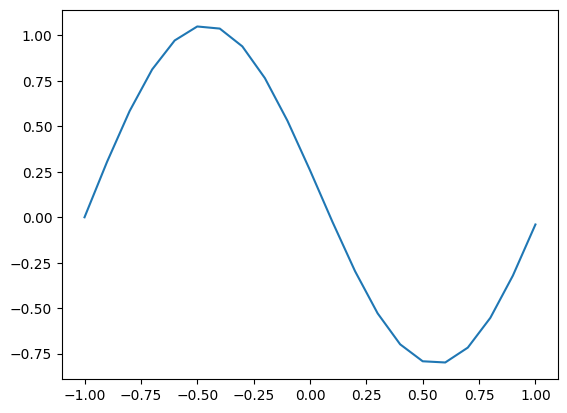

h = 0.5: L∞ = 0.526, L2 = 0.439, H1 = 1.464, cond(K) = 12.587
h = 0.25: L∞ = 0.298, L2 = 0.241, H1 = 0.734, cond(K) = 42.159
h = 0.125: L∞ = 0.243, L2 = 0.204, H1 = 0.425, cond(K) = 153.912
h = 0.0625: L∞ = 0.240, L2 = 0.197, H1 = 0.308, cond(K) = 585.584
h = 0.03125: L∞ = 0.240, L2 = 0.196, H1 = 0.272, cond(K) = 2281.527
h = 0.015625: L∞ = 0.240, L2 = 0.196, H1 = 0.262, cond(K) = 9003.864

Ordre de convergence estimé :
L∞ : 0.49 : pareil que pour L2 voir class 7 pour jutsif dans le tableau grand O(h^2)
L2  : 0.19 : proche de 2 parfait voir class 7 pour jutsif dans le tableau grand O(h^2)
H1  : 0.19 : proche de 1 parfait voir class 7 pour jutsif dans le tableau grand O(h)


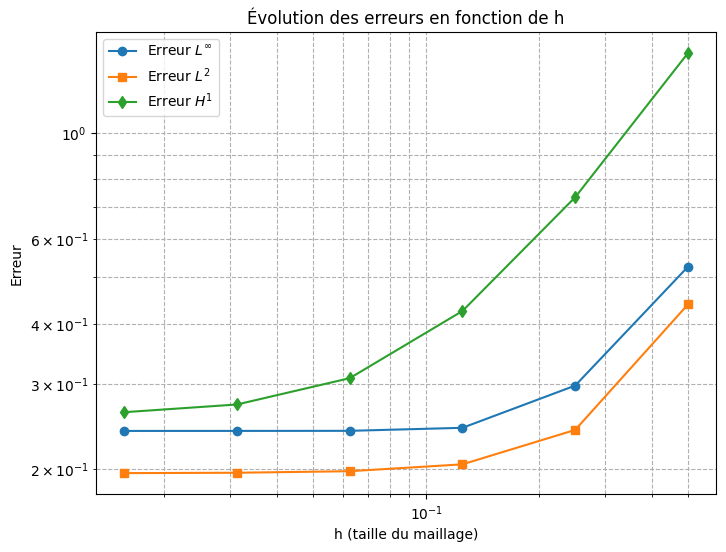

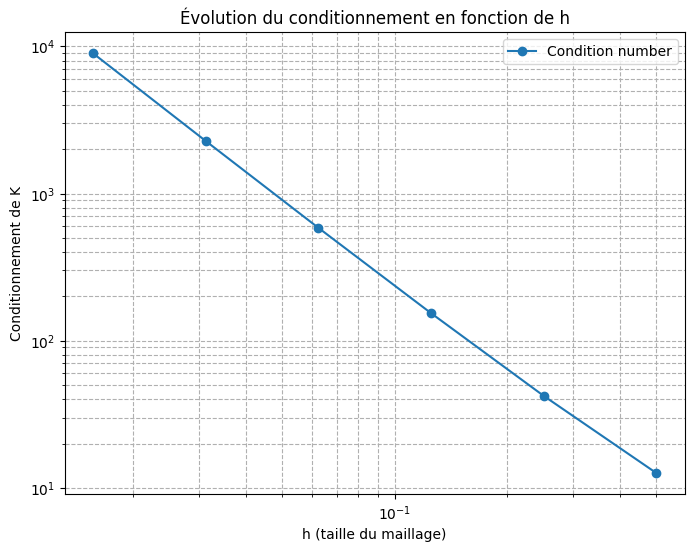

0

In [2112]:

def solve_poisson_robin(h):

    K = assemble_LHS_poisson(createmesh1D(h, boundaries_flags=[1,3]), H=lambda x: 3)
    F = assemble_RHS_poisson(createmesh1D(h, boundaries_flags=[1,3]), lambda x: 0.,
                             lambda x: 9 * np.sin(3 * x + 3),
                             lambda x: 3 * np.cos(6))
    
    K_LU = la.lu_factor(K)
    uh_robin = la.lu_solve(K_LU, F)

    return uh_robin

h = 0.1
mesh = createmesh1D(h, boundaries_flags=[1,3])
uh_robin = solve_poisson_robin(h)

print(f'Solution numérique pour équation de poisson avec conditions de Robin :\n u_h_robin = {uh_robin}')

plt.plot(createmesh1D(h)[0], uh_robin)
plt.show()

h_values = []
errors_Linf = []
errors_L2 = []
errors_H1 = []
condK_robin_values = []

for j in range(1, 7):
    h = 2**(-j)
    u_exact = np.sin(3*np.linspace(-1, 1, 10**4) + 3)
    uh_robin = solve_poisson_robin(h)
    mesh = createmesh1D(h, boundaries_flags=[1,3])
    x = np.linspace(-1, 1, 10**4)
    
    error_Linf = eval_uh_Linf(mesh, uh_robin, x, u_exact)
    error_L2_norm = eval_uh_L2norm(mesh, uh_robin, x, u_exact)
    error_H1_norm = eval_uh_H1norm(mesh, uh_robin, x, u_exact)

    K_robin = assemble_LHS_poisson(mesh, H = lambda x: 3)
    condK_robin = np.linalg.cond(K_robin)
    condK_robin_values.append(condK_robin)
    
    h_values.append(h)
    errors_Linf.append(error_Linf)
    errors_L2.append(error_L2_norm)
    errors_H1.append(error_H1_norm)
    
    print(f"h = {h}: L∞ = {error_Linf:.3f}, L2 = {error_L2_norm:.3f}, H1 = {error_H1_norm:.3f}, cond(K) = {condK_robin:.3f}")

convergence_H1, convergence_L2, convergence_Linf = linear_regression_convergence(h_values, errors_Linf, errors_L2, errors_H1)
trace(convergence_Linf, convergence_L2, convergence_H1, h_values, errors_Linf, errors_L2, errors_H1, condK_robin_values)

# Convergence rate :

Il réduit considérablement et apparemment c'est logique à voir pourquoi

# Conditionnement :

Il est aussi plus petit mais je sais pas encore pourquoi après c'est pas demandé donc on s'en branle un peu.

# Sparse test

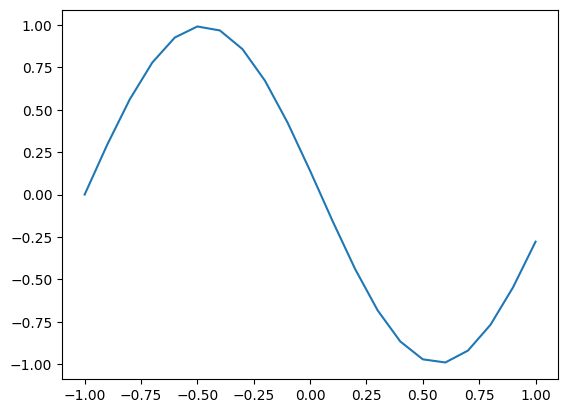

h = 0.5: L∞ = 0.353, L2 = 0.348, H1 = 1.429, cond(K) = 64.0
h = 0.25: L∞ = 0.111, L2 = 0.095, H1 = 0.679, cond(K) = 256.0
h = 0.125: L∞ = 0.029, L2 = 0.024, H1 = 0.333, cond(K) = 1024.0
h = 0.0625: L∞ = 0.007, L2 = 0.006, H1 = 0.166, cond(K) = 4096.0
h = 0.03125: L∞ = 0.002, L2 = 0.002, H1 = 0.082, cond(K) = 16384.0
h = 0.015625: L∞ = 0.000, L2 = 0.000, H1 = 0.041, cond(K) = 65536.0

Ordre de convergence estimé :
L∞ : 1.94 : pareil que pour L2 voir class 7 pour jutsif dans le tableau grand O(h^2)
L2  : 1.02 : proche de 2 parfait voir class 7 pour jutsif dans le tableau grand O(h^2)
H1  : 1.97 : proche de 1 parfait voir class 7 pour jutsif dans le tableau grand O(h)


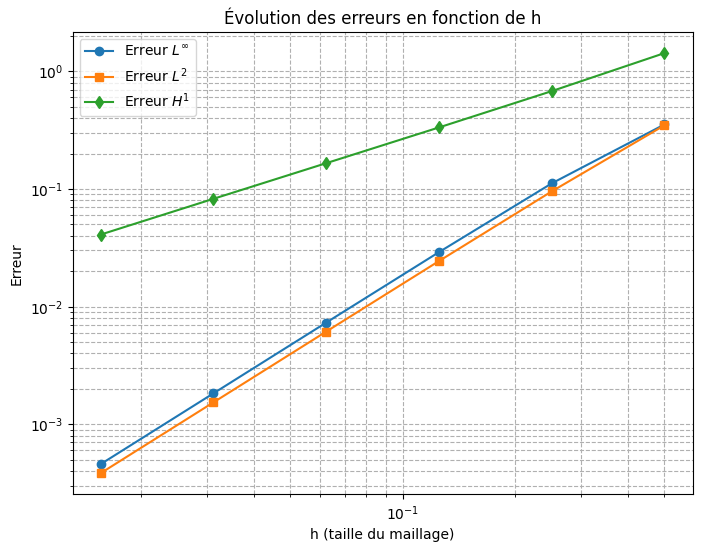

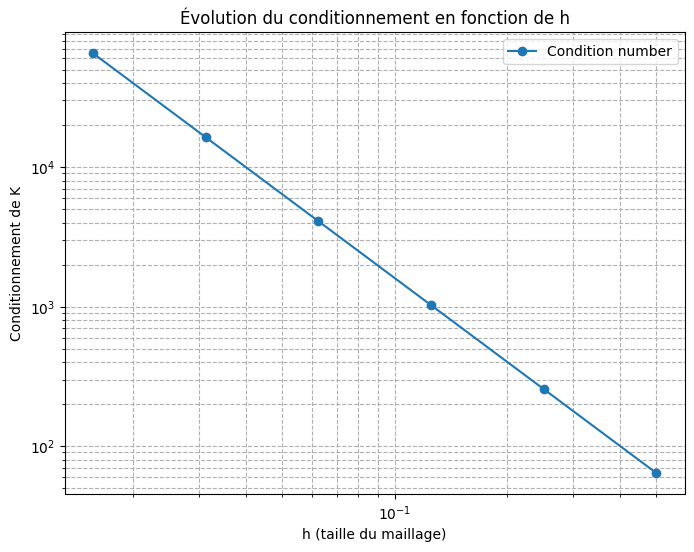

Non-homogeneous with sparse matrix :
Solution numérique pour équation de poisson non-homogène u_h2 = [-3.142 -2.848 -2.581 -2.364 -2.217 -2.152 -2.175 -2.285 -2.471 -2.717
 -3.002 -3.298 -3.581 -3.824 -4.007 -4.112 -4.13  -4.06  -3.909 -3.688
 -3.419]


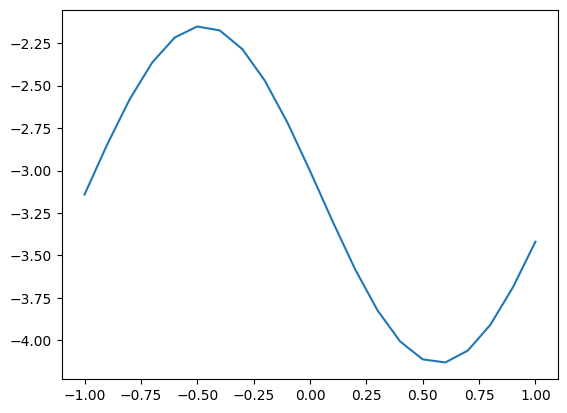

h = 0.5: L∞ = 0.353, L2 = 0.348, H1 = 1.429
h = 0.25: L∞ = 0.111, L2 = 0.095, H1 = 0.679
h = 0.125: L∞ = 0.029, L2 = 0.024, H1 = 0.333
h = 0.0625: L∞ = 0.007, L2 = 0.006, H1 = 0.166
h = 0.03125: L∞ = 0.002, L2 = 0.002, H1 = 0.082
h = 0.015625: L∞ = 0.000, L2 = 0.000, H1 = 0.041

Ordre de convergence estimé :
L∞ : 0.00 : pareil que pour L2 voir class 7 pour jutsif dans le tableau grand O(h^2)
L2  : -0.00 : proche de 2 parfait voir class 7 pour jutsif dans le tableau grand O(h^2)
H1  : 0.00 : proche de 1 parfait voir class 7 pour jutsif dans le tableau grand O(h)


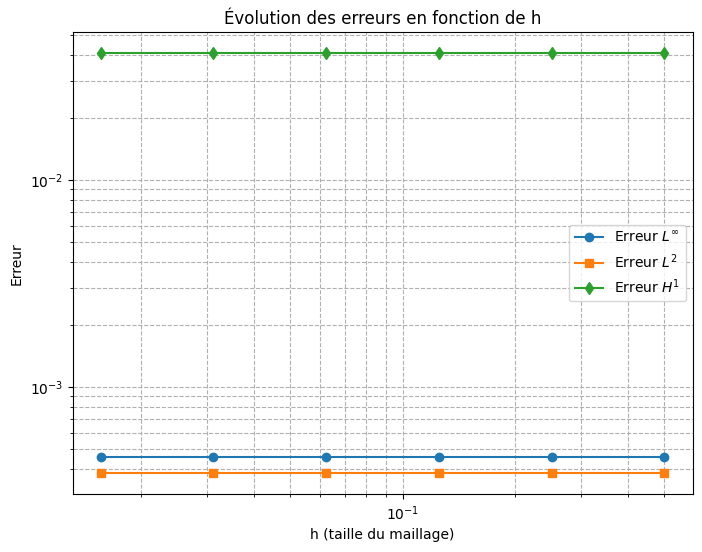

ValueError: x and y must have same first dimension, but have shapes (6,) and (0,)

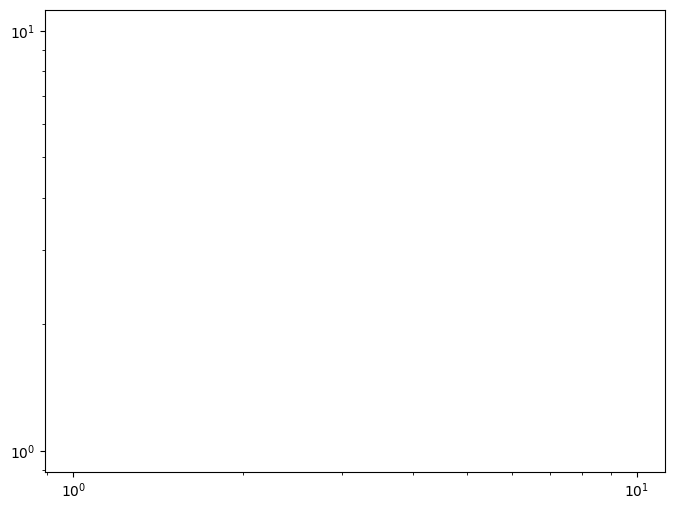

In [2113]:
h = 0.1

def createmesh1D(h, domain=(-1, 1), boundaries_flags=[1, 2]):

    a, b = domain
    N = int((b - a) / h)
    h = (b - a) / N  # ensure integer number of elements
    
    grid = np.linspace(a, b, N + 1)
    elements = [[i, i + 1] for i in range(N)]
    endpoints = [0, N]
    boundaries = [a, b]
    boundaries_flags = boundaries_flags
    
    return grid, elements, endpoints, boundaries, boundaries_flags

def assemble_LHS_poisson_sparse(mesh, H = lambda x: 1):
    
    grid, elements, endpoints, boundaries, boundaries_flags = mesh

    K_ref = np.array([[-1., 1.], [1., -1.]])
    N=len(grid)
    K = sp.lil_matrix((N, N))

    for el in elements :

        i, j = el
        h = grid[i] - grid[j]
        K_temp =  (1. / h) * K_ref

        K[i,i] += K_temp[0,0]
        K[i,j] += K_temp[0,1]
        K[j,i] += K_temp[1,0]
        K[j,j] += K_temp[1,1]

    for j, flag in zip(endpoints, boundaries_flags):
        if flag == 1: 
            K[j, :] = 0
            K[j, j] = 1
        elif flag == 3:  
            K[j, j] += H(grid[j])

    K_csr = K.tocsr()

    return K_csr

def solve_poisson_sparse(h):
    """
    Function to compute the P1-FEM solution uh with mesh-size h.
    """
    K_csr = assemble_LHS_poisson_sparse(createmesh1D(h))
    F = assemble_RHS_poisson(createmesh1D(h), lambda x: 0.,
                             lambda x: 9 * np.sin(3 * x + 3),
                             lambda x: 3 * np.cos(6))
    
    
    uh = spla.spsolve(K_csr, F)
    return uh


uh = solve_poisson_sparse(h)
#print(np.round(uh, 3))
plt.plot(createmesh1D(h)[0], uh)
plt.show()


h_values = []
errors_Linf = []
errors_L2 = []
errors_H1 = []
condK_values = []

for j in range(1, 7):

    h = 2**(-j)
    uh = solve_poisson_sparse(h)
    mesh = createmesh1D(h)
    x = np.linspace(-1, 1, 10**4)
    u_exact = np.sin(3*x + 3)
    
    error_Linf = eval_uh_Linf(mesh, uh, x, u_exact)
    error_L2_norm = eval_uh_L2norm(mesh, uh, x, u_exact)
    error_H1_norm = eval_uh_H1norm(mesh, uh, x, u_exact)

    K_csr = assemble_LHS_poisson_sparse(createmesh1D(h))
    condK = spla.norm(K_csr, ord=np.inf) * spla.norm(K_csr, ord=1)
    condK_values.append(condK)
    
    h_values.append(h)
    errors_Linf.append(error_Linf)
    errors_L2.append(error_L2_norm)
    errors_H1.append(error_H1_norm)
    
    print(f"h = {h}: L∞ = {error_Linf:.3f}, L2 = {error_L2_norm:.3f}, H1 = {error_H1_norm:.3f}, cond(K) = {condK}")

convergence_Linf, convergence_H1, convergence_L2 = linear_regression_convergence(h_values, errors_Linf, errors_L2, errors_H1)

trace(convergence_Linf, convergence_L2, convergence_H1, h_values, errors_Linf, errors_L2, errors_H1, condK_values)



print("Non-homogeneous with sparse matrix :")

def solve_poisson_nonhomogeneous_sparse(h):
    """
    Function to compute the P1-FEM solution uh of the problem with non-homogeneous Dirichlet BCs with mesh-size h.
    """
    K = assemble_LHS_poisson_sparse(createmesh1D(h))
    F = assemble_RHS_poisson(createmesh1D(h), lambda x: 0.,
                             lambda x: 9 * np.sin(3 * x + 3),
                             lambda x: 3 * np.cos(6))
    
    uh2 = spla.spsolve(K,F) - np.pi
    return uh2

h = 0.1
uh2 = solve_poisson_nonhomogeneous_sparse(h)
print(f'Solution numérique pour équation de poisson non-homogène u_h2 = {np.round(uh2,3)}')
plt.plot(createmesh1D(h)[0], uh2)
plt.show()

h_values_in = []
errors_Linf_in = []
errors_L2_in = []
errors_H1_in = []
condK_values_in = []

for j in range(1, 7):
    h = 2**(-j)
    u_exact = np.sin(3*np.linspace(-1, 1, 10**4) + 3) - np.pi
    uh2 = solve_poisson_nonhomogeneous_sparse(h)
    mesh = createmesh1D(h)
    x = np.linspace(-1, 1, 10**4)
    
    error_Linf_in = eval_uh_Linf(mesh, uh2, x, u_exact)
    error_L2_norm_in = eval_uh_L2norm(mesh, uh2, x, u_exact)
    error_H1_norm_in = eval_uh_H1norm(mesh, uh2, x, u_exact)
    
    h_values_in.append(h)
    errors_Linf_in.append(error_Linf)
    errors_L2_in.append(error_L2_norm)
    errors_H1_in.append(error_H1_norm)
    
    print(f"h = {h}: L∞ = {error_Linf_in:.3f}, L2 = {error_L2_norm_in:.3f}, H1 = {error_H1_norm_in:.3f}")

convergence_Linf_in, convergence_L2_in, convergence_H1_in = linear_regression_convergence(h_values_in, errors_Linf_in, errors_L2_in, errors_H1_in,)

trace(convergence_Linf_in, convergence_L2_in, convergence_H1_in, h_values_in, errors_Linf_in, errors_L2_in, errors_H1_in, condK_values_in)